In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from datetime import datetime

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.metrics import accuracy_score

%matplotlib inline
sns.set_style('darkgrid') #my default is "whitegrid"

In [138]:
#load csv file data with headers

location = "datasets/Kickstartercombo.csv"
df = pd.read_csv(location)

In [139]:
df.dtypes

Unnamed: 0            int64
ID                    int64
name                 object
main_category        object
category             object
country              object
state                object
goal                float64
pledged             float64
currency             object
launched             object
deadline             object
backers               int64
usd pledged         float64
usd_goal_real       float64
usd_pledged_real    float64
dtype: object

In [140]:
df.count()

Unnamed: 0          702411
ID                  702411
name                702403
main_category       702411
category            702411
country             702411
state               702411
goal                702411
pledged             702411
currency            702411
launched            702411
deadline            702411
backers             702411
usd pledged         694817
usd_goal_real       378661
usd_pledged_real    378661
dtype: int64

In [141]:
#look for missing data
df.isnull().sum()

Unnamed: 0               0
ID                       0
name                     8
main_category            0
category                 0
country                  0
state                    0
goal                     0
pledged                  0
currency                 0
launched                 0
deadline                 0
backers                  0
usd pledged           7594
usd_goal_real       323750
usd_pledged_real    323750
dtype: int64

In [142]:
#look for duplicate data
dupe = df.duplicated()
df.loc[dupe]

,Unnamed: 0,ID,name,main_category,category,country,state,goal,pledged,currency,launched,deadline,backers,usd pledged,usd_goal_real,usd_pledged_real


In [143]:
df.describe()

,Unnamed: 0,ID,goal,pledged,backers,usd pledged,usd_goal_real,usd_pledged_real
count,702411.000000,7.024110e+05,7.024110e+05,7.024110e+05,702411.000000,6.948170e+05,3.786610e+05,3.786610e+05
mean,351205.000000,1.074829e+09,4.817642e+04,9.223828e+03,103.726589,7.405969e+03,4.545440e+04,9.058924e+03
std,202768.734302,6.192006e+08,1.162920e+06,9.286016e+04,919.654297,8.144094e+04,1.152950e+06,9.097334e+04
min,0.000000,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,1.000000e-02,0.000000e+00
25%,175602.500000,5.379594e+08,2.000000e+03,3.000000e+01,2.000000,2.024000e+01,2.000000e+03,3.100000e+01
50%,351205.000000,1.075562e+09,5.000000e+03,6.150000e+02,12.000000,4.560000e+02,5.500000e+03,6.243300e+02
75%,526807.500000,1.610544e+09,1.505600e+04,4.020000e+03,55.000000,3.261000e+03,1.550000e+04,4.050000e+03
max,702410.000000,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,1.663614e+08,2.033899e+07


In [144]:
df.head()
df['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended'], dtype=object)

In [145]:
pd.value_counts(df['state']) 

failed        366327
successful    247204
canceled       71193
live            7238
undefined       7124
suspended       3325
Name: state, dtype: int64

In [146]:
ff = df[df['usd_goal_real'].notnull()] 
ff = df.loc[(df['state'] == 'failed') | (df['state'] == 'successful') ] #find diamonds of best cut and clarit

In [147]:
ff.head()
ff.shape

(613531, 16)

In [148]:
ff = ff.drop(['Unnamed: 0','ID', 'usd pledged', 'usd_goal_real', 'usd_pledged_real'], axis = 1)

# Calculate Percentage of Money pledged over goal

In [149]:
#calculate percentage of pledged vs goal
def find_percentmoney(x, y):
    return x/y
    
ff['Percent'] = find_percentmoney(ff['pledged'], df['goal'])

# Find time passed from launch to deadline

In [150]:
def find_timepassed(x,y):
    dated = pd.to_datetime(x)
    datel = pd.to_datetime(y)
    return dated-datel

ff['Timed'] = find_timepassed(ff['deadline'],ff['launched'])

In [151]:
ff.head()

,name,main_category,category,country,state,goal,pledged,currency,launched,deadline,backers,Percent,Timed
0,The Songs of Adelaide & Abullah,Publishing,Poetry,GB,failed,1000.0,0.0,GBP,2015-08-11 12:12:00,2015-10-09 11:36:00,0,0.000000,58 days 23:24:00
1,Where is Hank?,Film & Video,Narrative Film,US,failed,45000.0,220.0,USD,2013-01-12 00:20:00,2013-02-26 00:20:00,3,0.004889,45 days 00:00:00
2,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,failed,5000.0,1.0,USD,2012-03-17 03:24:00,2012-04-16 04:24:00,1,0.000200,30 days 01:00:00
4,Monarch Espresso Bar,Food,Restaurants,US,successful,50000.0,52375.0,USD,2016-02-26 13:38:00,2016-04-01 13:38:00,224,1.047500,35 days 00:00:00
5,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,US,successful,1000.0,1205.0,USD,2014-12-01 18:30:00,2014-12-21 18:30:00,16,1.205000,20 days 00:00:00


In [152]:
ff = ff.drop(['launched','deadline','category'], axis = 1)
ff.head()

,name,main_category,country,state,goal,pledged,currency,backers,Percent,Timed
0,The Songs of Adelaide & Abullah,Publishing,GB,failed,1000.0,0.0,GBP,0,0.000000,58 days 23:24:00
1,Where is Hank?,Film & Video,US,failed,45000.0,220.0,USD,3,0.004889,45 days 00:00:00
2,ToshiCapital Rekordz Needs Help to Complete Album,Music,US,failed,5000.0,1.0,USD,1,0.000200,30 days 01:00:00
4,Monarch Espresso Bar,Food,US,successful,50000.0,52375.0,USD,224,1.047500,35 days 00:00:00
5,Support Solar Roasted Coffee & Green Energy! ...,Food,US,successful,1000.0,1205.0,USD,16,1.205000,20 days 00:00:00


# Sort data by Percent

In [153]:
ff = ff.sort_values('Percent', ascending = False)
ff

,name,main_category,country,state,goal,pledged,currency,backers,Percent,Timed
692926,VULFPECK /// The Beautiful Game,Music,US,successful,1.00,104277.89,USD,3917,104277.890,59 days 14:55:57
315659,VULFPECK /// The Beautiful Game,Music,US,successful,1.00,104277.89,USD,3917,104277.890,59 days 23:57:00
509846,Re-covering with Friends,Music,US,successful,1.00,68764.10,USD,955,68764.100,59 days 04:55:33
308395,VULFPECK /// Thrill of the Arts,Music,US,successful,1.00,55266.57,USD,1673,55266.570,59 days 20:29:00
684471,VULFPECK /// Thrill of the Arts,Music,US,successful,1.00,55266.57,USD,1673,55266.570,59 days 04:28:04
400040,Energy Hook,Games,US,successful,1.00,41535.01,USD,1622,41535.010,30 days 22:37:22
65295,Energy Hook,Games,US,successful,1.00,41535.01,USD,1622,41535.010,30 days 22:38:00
405118,Band of Brothers 2nd Chance,Games,US,successful,1.00,32843.00,USD,268,32843.000,20 days 23:30:48
69610,Band of Brothers 2nd Chance,Games,US,successful,1.00,32843.00,USD,268,32843.000,21 days 01:31:00
244254,CLOCKWRIGHT: Large-Scale Analogue Time Machines,Art,US,successful,1.00,27588.23,USD,162,27588.230,30 days 00:00:00


# Descriptive Analysis

In [154]:
ff.describe()

,goal,pledged,backers,Percent,Timed
count,6.135310e+05,6.135310e+05,613531.000000,613531.000000,613531
mean,4.312562e+04,1.006134e+04,114.300418,3.390704,33 days 17:52:11.853595
std,1.084342e+06,9.825562e+04,979.716434,277.217059,12 days 19:22:30.168977
min,1.000000e-02,0.000000e+00,0.000000,0.000000,0 days 00:07:17
25%,2.000000e+03,5.000000e+01,2.000000,0.007500,29 days 04:02:06
50%,5.000000e+03,7.780000e+02,15.000000,0.197662,30 days 00:00:00
75%,1.500000e+04,4.556000e+03,62.000000,1.091657,36 days 02:59:08.500000
max,1.000000e+08,2.033899e+07,219382.000000,104277.890000,92 days 00:00:00


In [155]:
ff.isnull().sum()

name             6
main_category    0
country          0
state            0
goal             0
pledged          0
currency         0
backers          0
Percent          0
Timed            0
dtype: int64

In [156]:
pd.value_counts(ff['main_category']) 

Film & Video      107658
Music              86965
Publishing         65731
Games              50950
Technology         48498
Art                47446
Design             45397
Food               40953
Fashion            35615
Theater            19582
Photography        18357
Comics             17795
Crafts             14128
Journalism          7687
Dance               6768
Graphic Novels         1
Name: main_category, dtype: int64

# Bar Chart for Main Categories

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

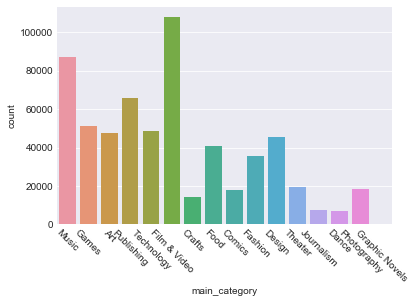

In [157]:
#create a bar plot main categories
sns.countplot(x='main_category',
              data=ff, )

plt.xticks(rotation=-45)

# Pivot table of state, percent, backers for each Category

In [158]:
pd.pivot_table(ff, values = ['Percent', 'backers'], index = ['main_category','state'])

Percent     backers
main_category  state                            
Art            failed       0.097999    8.936822
               successful   6.121737   87.677161
Comics         failed       0.146326   21.255305
               successful  12.548762  235.145425
Crafts         failed       0.079965    5.987524
               successful  10.618163   94.510032
Dance          failed       0.107756    9.652193
               successful   1.240941   63.549752
Design         failed       0.132148   32.252000
               successful   5.228227  619.527538
Fashion        failed       0.083470    9.918414
               successful   3.538515  221.910714
Film & Video   failed       0.082115   15.281352
               successful   3.565142  152.813280
Food           failed       0.073888   12.749333
               successful   3.193684  179.927502
Games          failed       0.118531   45.150434
               successful  20.051108  832.789541
Graphic Novels failed       0.033333    1.000000
Journalism     failed       0.050158    7.781051
               successful   1.840642  152.488310
Music          failed       0.089376    9.302367
               successful  14.482567  101.194216
Photography    failed       0.085603    9.163867
               successful   1.676217  106.378400
Publishing     failed       0.081659   10.143476
               successful   5.246907  155.146052
Technology     failed       0.070146   20.817223
               successful  13.489175  720.306468
Theater        failed       0.109110   11.737342
               successful   1.617403   70.554066

In [159]:
fff = ff.loc[(df['state'] == 'failed')]
sff = ff.loc[(df['state'] == 'successful')]


# Bar Chart for Failed by Category

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

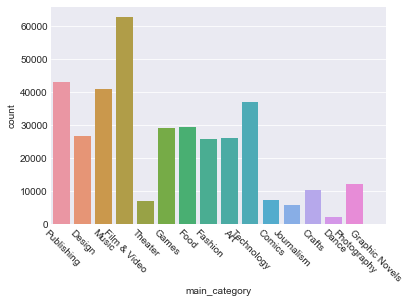

In [160]:
#create a bar plot for only failed
sns.countplot(x='main_category',
              data=fff, )

plt.xticks(rotation=-45)

In [175]:
#sns.countplot?

# Bar chart for Success by Category

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

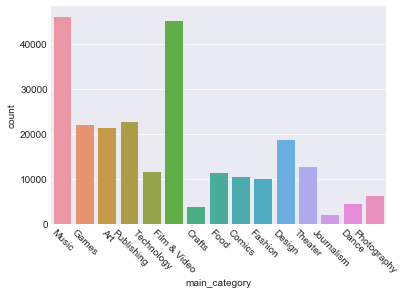

In [161]:
#create a bar plot for only successes
sns.countplot(x='main_category',
              data=sff, )

plt.xticks(rotation=-45)

# Calculate Percentage of Success

In [162]:
#calculate percentage of success
pd.value_counts(fff['main_category'])


Film & Video      62612
Publishing        43150
Music             40980
Technology        36996
Food              29601
Games             29036
Design            26877
Art               26259
Fashion           25703
Photography       12144
Crafts            10340
Comics             7446
Theater            7051
Journalism         5805
Dance              2326
Graphic Novels        1
Name: main_category, dtype: int64

In [163]:
pd.value_counts(sff['main_category'])

Music           45985
Film & Video    45046
Publishing      22581
Games           21914
Art             21187
Design          18520
Theater         12531
Technology      11502
Food            11352
Comics          10349
Fashion          9912
Photography      6213
Dance            4442
Crafts           3788
Journalism       1882
Name: main_category, dtype: int64

In [164]:
pff = pd.DataFrame(pd.value_counts(sff['main_category'])/(pd.value_counts(sff['main_category']) + pd.value_counts(fff['main_category'])))
pff = pff.reset_index() 

In [165]:
pff.columns = ['Category','Percent Success']
pff = pff.sort_values('Percent Success', ascending = False)


# Percentage of Success for each Category

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

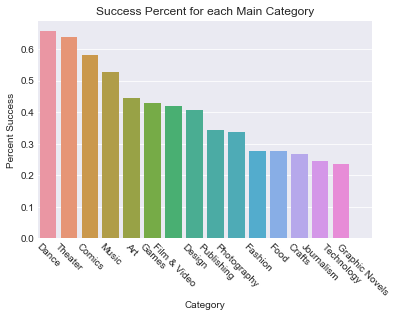

In [166]:
#create a bar plot for only successes
sns.barplot('Category', 'Percent Success',
              data=pff, )
plt.title('Success Percent for each Main Category')
plt.xticks(rotation=-45)

In [167]:
pd.value_counts(ff['country'])

US      491186
GB       53331
CA       22282
AU       11811
DE        5567
NL        4284
FR        4079
IT        3763
ES        2963
SE        2575
NZ        2267
DK        1598
MX        1415
IE        1156
CH        1041
NO        1012
BE         852
AT         768
HK         524
SG         524
N,"0       210
N,0"       210
LU          90
JP          23
Name: country, dtype: int64

# Calculating Percent Success by Country

In [168]:
pd.value_counts(fff['country'])
pd.value_counts(sff['country'])
pff = pd.DataFrame(pd.value_counts(sff['country'])/(pd.value_counts(sff['country']) + pd.value_counts(fff['country'])))
pff = pff.reset_index() 
pff.columns = ['Country','Percent Success']
pff

,Country,Percent Success
0,AT,0.217448
1,AU,0.293455
2,BE,0.271127
3,CA,0.323400
4,CH,0.262248
5,DE,0.263517
6,DK,0.369837
7,ES,0.248059
8,FR,0.348370
9,GB,0.401811


In [169]:
pff = pff.sort_values('Percent Success', ascending = False)
pff = pff[2:]
pff

,Country,Percent Success
10,HK,0.438931
23,US,0.417762
9,GB,0.401811
22,SG,0.400763
6,DK,0.369837
14,LU,0.355556
8,FR,0.348370
20,NZ,0.343185
21,SE,0.327767
3,CA,0.323400


# Percentage of Success for Each Country

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

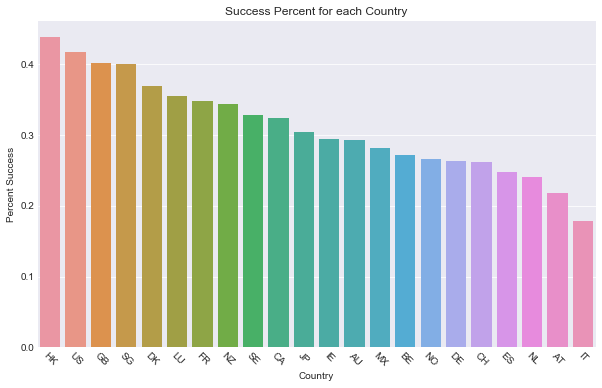

In [170]:
#create a bar plot for only successes
plt.figure(figsize=(10,6))
sns.barplot('Country', 'Percent Success',
              data=pff, )
plt.title('Success Percent for each Country')
plt.xticks(rotation=-45)


# For Top 5 countries, graph of pledged vs backers

Text(0.5,1,'Pledged vs backers')

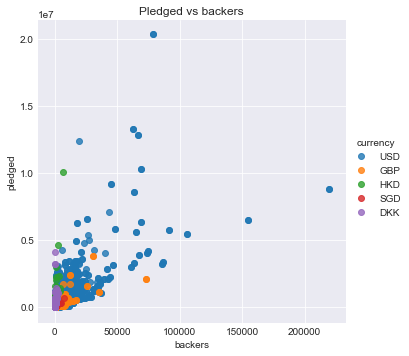

In [171]:
coff = ff.loc[(ff['country'] == 'HK') | ((ff['country'] == 'US') | (ff['country'] == 'GB') | (ff['country'] == 'SG') | (ff['country'] == 'DK'))] #
plt.figure(figsize=(10,6))
sns.lmplot(x='backers', y='pledged', data=coff, fit_reg=False, hue = 'currency')
plt.title('Pledged vs backers')

# Removing Outliers

In [172]:
#Standard Deviation Method

meangrade = coff['backers'].mean()
stdgrade = coff['backers'].std()
toprange = meangrade + stdgrade * 1.96
botrange = meangrade - stdgrade * 1.96

copydf = coff #because we don't want to mess up the original df
copydf = copydf.drop(copydf[copydf['backers'] > toprange].index)
copydf = copydf.drop(copydf[copydf['backers'] < botrange].index)

copydf.head()


meangrade = coff['pledged'].mean()
stdgrade = coff['pledged'].std()
toprange = meangrade + stdgrade * 1.96
botrange = meangrade - stdgrade * 1.96

copydf = coff #because we don't want to mess up the original df
copydf = copydf.drop(copydf[copydf['pledged'] > toprange].index)
copydf = copydf.drop(copydf[copydf['pledged'] < botrange].index)



# For Top 5 countries, graph of pledged vs backers without outliers

Text(0.5,1,'Pledged vs Backers by Currency')

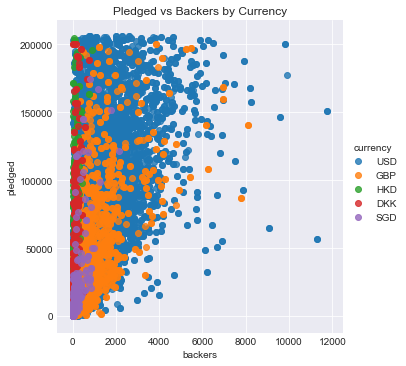

In [173]:
plt.figure(figsize=(10,6))
sns.lmplot(x='backers', y='pledged', data=copydf, fit_reg=False, hue = 'currency')
plt.title('Pledged vs Backers by Currency')

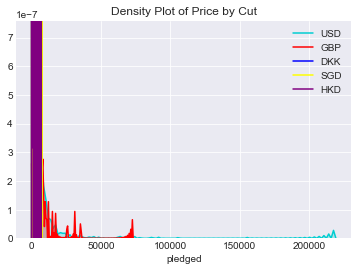

In [174]:
#plot price by cut

ax = sns.kdeplot(coff['backers'][coff['currency'] == 'USD'], 
                 color="darkturquoise",
                 shade=True)

sns.kdeplot(coff['backers'][coff['currency'] == 'GBP'], 
            color="red",
            shade=True)

sns.kdeplot(coff['backers'][coff['currency'] == 'DKK'], 
            color="blue",
            shade=True)

sns.kdeplot(coff['backers'][coff['currency'] == 'SGD'], 
            color="yellow",
            shade=True)

sns.kdeplot(coff['backers'][coff['currency'] == 'HKD'], 
           color="purple",
           shade=True)

plt.legend (['USD', 'GBP', 'DKK', 'SGD', 'HKD'])
plt.title("Density Plot of Price by Cut")

ax.set(xlabel='pledged')
plt.show()